In [88]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

In [89]:
data_frame = pd.read_csv("Train_TEC_mar17.csv")

In [90]:
data_frame.head()

,Date,Month,Year,Time,LT,TEC
0,1,3,2017,0.016389,5.311333,2.067562
1,1,3,2017,0.049722,5.344670,2.082707
2,1,3,2017,0.083056,5.378006,2.004272
3,1,3,2017,0.116389,5.411343,1.736569
4,1,3,2017,0.149722,5.444679,1.758503


In [91]:
data_frame.drop(["Date", "Month", "Year", "Time"], axis = 1, inplace = True)

In [92]:
data_frame.head()

,LT,TEC
0,5.311333,2.067562
1,5.344670,2.082707
2,5.378006,2.004272
3,5.411343,1.736569
4,5.444679,1.758503


In [93]:
df = pd.DataFrame(data_frame["TEC"])

In [94]:
df.head()

,TEC
0,2.067562
1,2.082707
2,2.004272
3,1.736569
4,1.758503


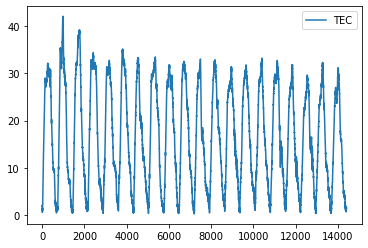

In [95]:
df.plot()

In [96]:
train = df[:-1440]
test = df[-1440:]
train.shape, test.shape

((12960, 1), (1440, 1))

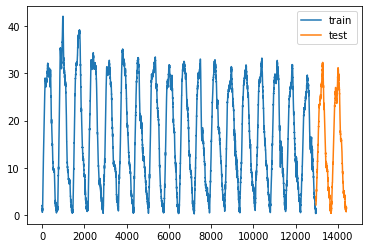

In [97]:
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [98]:
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [99]:
train_sc

array([[0.04266831],
       [0.04303103],
       [0.04115251],
       ...,
       [0.02035242],
       [0.01636847],
       [0.02202376]])

In [100]:
test_sc

array([[0.04565388],
       [0.04605349],
       [0.05475397],
       ...,
       [0.02464814],
       [0.02412893],
       [0.03227832]])

In [101]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [102]:
X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [103]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model

In [106]:
from keras.layers import LSTM
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(7, input_shape=(1, X_train.shape[1]), activation='tanh', kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
r2_train = r2_score(y_train, y_train_pred_lstm)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
r2_test = r2_score(y_test, y_pred_test_lstm)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))

ValueError: Error when checking target: expected dense_1 to have shape (2,) but got array with shape (1,)

In [78]:
model_lstm.save('LSTM_NonShift.h5')
model_lstm = load_model('LSTM_NonShift.h5')

In [79]:
score_lstm= model_lstm.evaluate(X_tst_t, y_test, batch_size=1)

1439/1439 [==============================] - 1s 397us/step


In [80]:
print('LSTM: %f'%score_lstm)

LSTM: 0.022558


In [81]:
y_pred_test_LSTM = model_lstm.predict(X_tst_t)

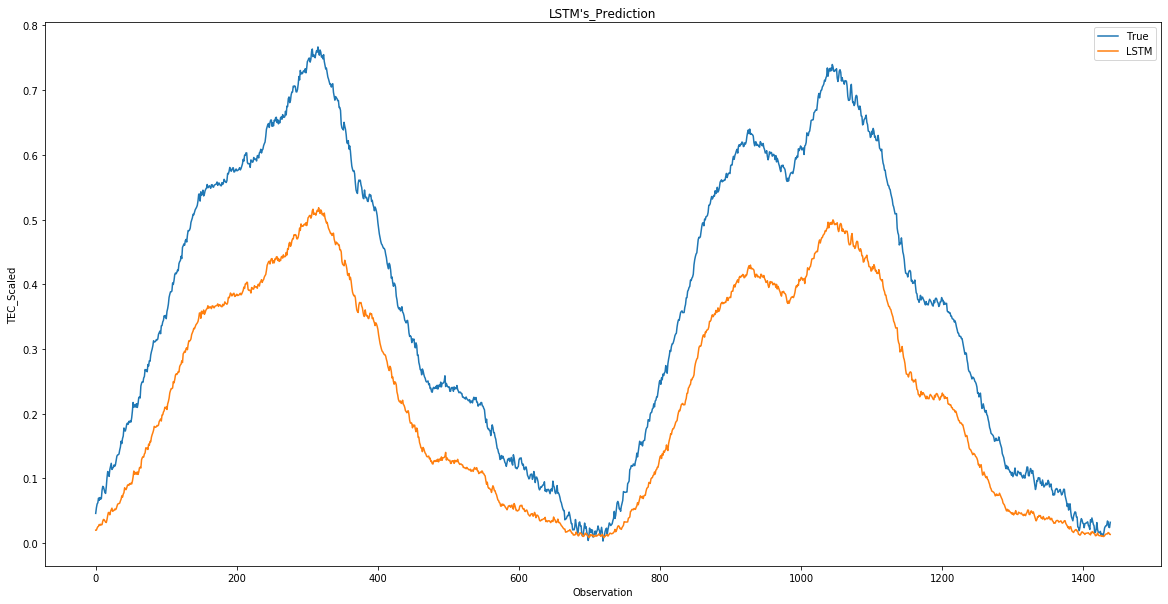

In [115]:
plt.figure(figsize=(20,10))

plt.plot(y_test, label='True')
plt.plot(y_pred_test_LSTM, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('TEC_Scaled')
plt.legend()
plt.show()

In [83]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_test, y_pred_test_LSTM))

rms

0.1501933638469239

In [84]:
y_test

array([[0.04605349],
       [0.05475397],
       [0.06051046],
       ...,
       [0.02464814],
       [0.02412893],
       [0.03227832]])

In [85]:
y_pred_test_LSTM

array([[0.02008623],
       [0.02022058],
       [0.02326137],
       ...,
       [0.01600277],
       [0.0136922 ],
       [0.01355159]], dtype=float32)

In [107]:
rescaled_original = sc.inverse_transform(y_test)
rescaled_predicted = sc.inverse_transform(y_pred_test_LSTM)

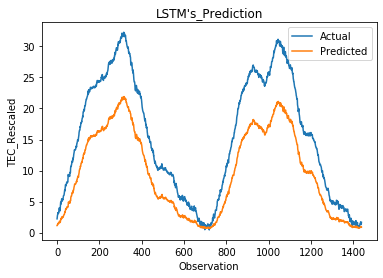

In [109]:
plt.plot(rescaled_original, label='Actual')
plt.plot(rescaled_predicted, label='Predicted')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('TEC_Rescaled')
plt.legend()
plt.show()

In [110]:
rescaled_original

array([[2.20890666],
       [2.57218469],
       [2.81254025],
       ...,
       [1.3151513 ],
       [1.29347241],
       [1.63374075]])

In [114]:
rescaled_predicted

array([[1.1246742],
       [1.1302838],
       [1.2572484],
       ...,
       [0.9541744],
       [0.8576991],
       [0.8518282]], dtype=float32)